In [1]:
import time
import sys

sys.path.append('/home/cjw/Code/Unet')

from skimage.io import imread
from matplotlib import pyplot as plt
import numpy as np

import unet
%matplotlib inline

/home/cjw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf

In [4]:
params = dict()

params['width'] = 256
params['height'] = 256
params['depth'] = 96
params['nchannels'] = 1
params['channels'] = [1]
params['nepochs'] = [1]
params['batchsize'] = [2]
params['learning_rate'] = 0.001
params['restore'] = False
params['latent_size'] = 1
params['enc_sizes'] = [[16,3], [32, 3], [64, 3], [128, 3]]
params['dec_sizes'] = [[64,3], [32, 3], [16, 3], [params['nchannels'], 3]]
params['droprate'] = 0
params['stdev'] = 0.08

In [14]:

tf.reset_default_graph()
u = unet.unet3d(params)


In [15]:
u.read_images('/media/cjw/Data/Nuclei.tif')
u.x = u.x[:,:,:,:,:]
u.x.shape

(36, 256, 256, 96, 2)

In [16]:

images = tf.placeholder(tf.float32, (None, 256, 256, 96, params['nchannels']))
masks = tf.placeholder(tf.float32, (None, 256, 256, 96, params['nchannels']))

In [17]:
enc = u.create_encoder(images, True)

[16, 3]
[32, 3]
[64, 3]
[128, 3]


In [18]:
d = u.create_decoder()
u.create_loss(masks)
u.create_opt()

3 Tensor("Maximum_5:0", shape=(?, 32, 32, 12, 64), dtype=float32)
2 Tensor("Maximum_3:0", shape=(?, 64, 64, 24, 32), dtype=float32)
1 Tensor("Maximum_1:0", shape=(?, 128, 128, 48, 16), dtype=float32)
0 Tensor("Placeholder:0", shape=(?, 256, 256, 96, 1), dtype=float32)


In [19]:
sess = tf.Session()

In [20]:
sess.run(tf.global_variables_initializer())

4370870.5


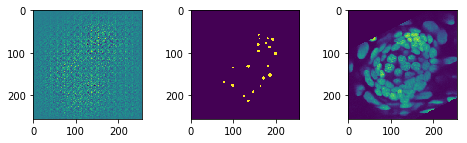

4299117.0


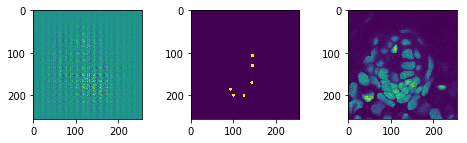

489978.97


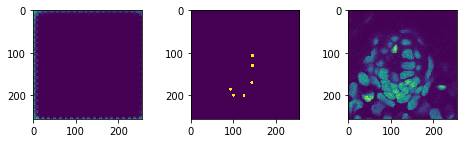

212376.94


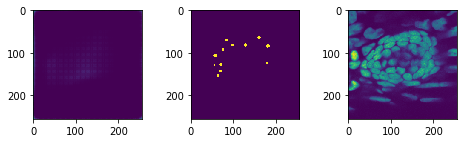

103566.914


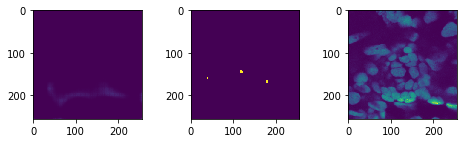

120432.66


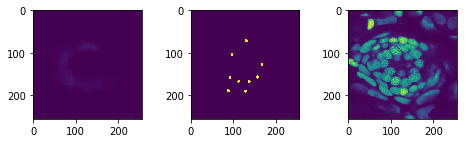

92374.54


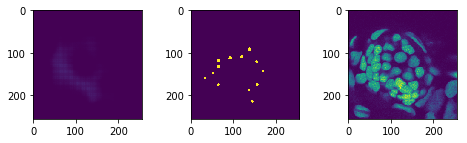

91888.016


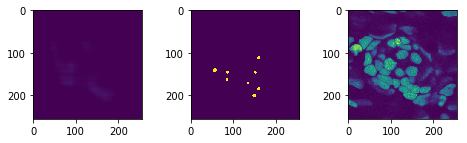

95239.64


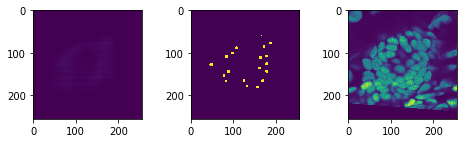

80239.31


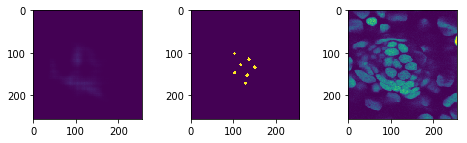

76307.47


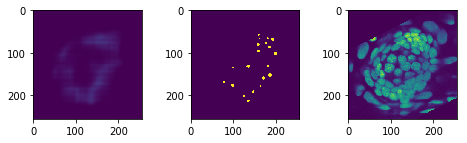

80713.34


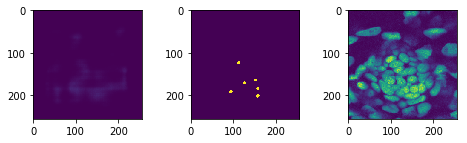

79833.06


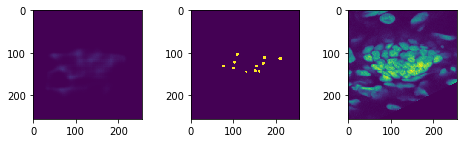

76868.34


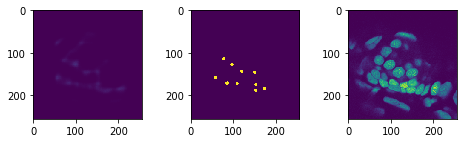

77409.016


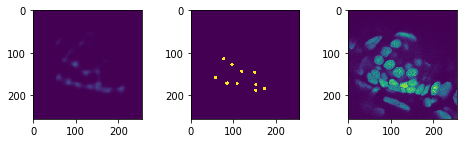

77049.13


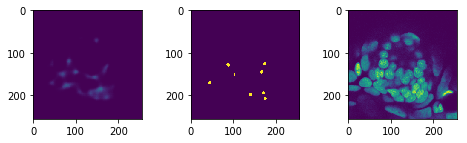

65562.81


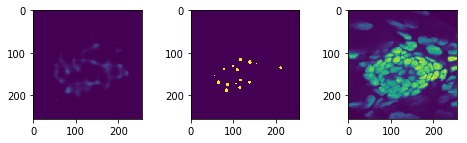

56581.83


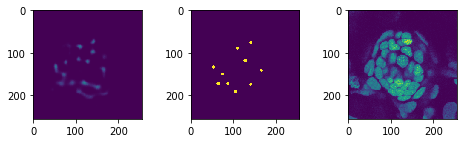

57398.883


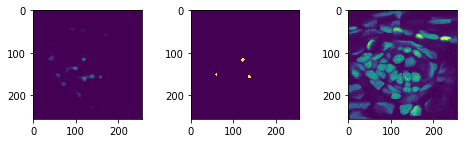

54739.508


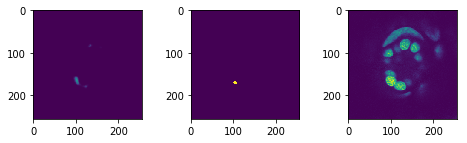

52868.617


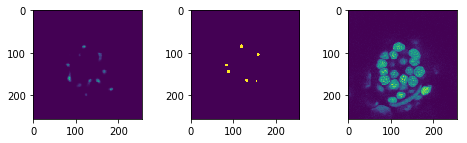

49995.918


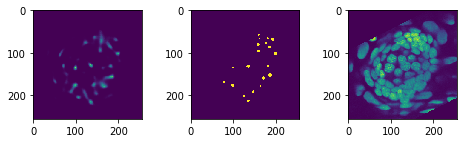

40837.883


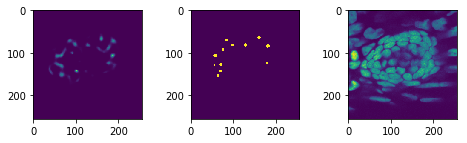

40097.82


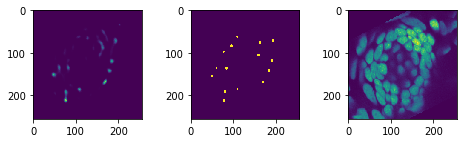

35685.93


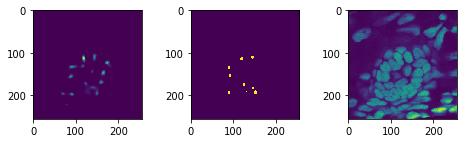

106778.59


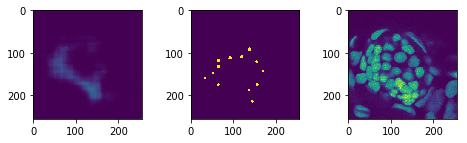

84307.23


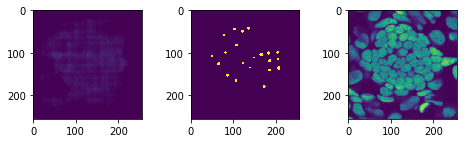

71623.06


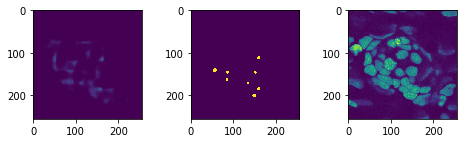

62527.043


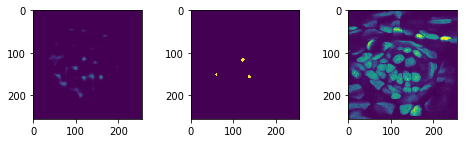

56622.83


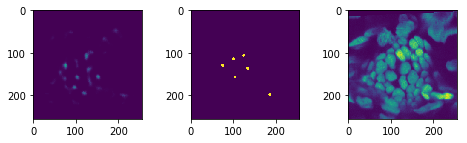

52451.508


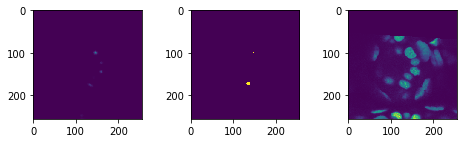

50997.902


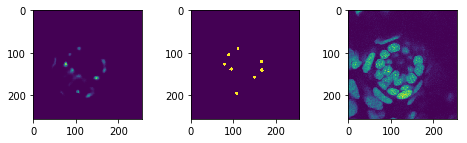

43741.21


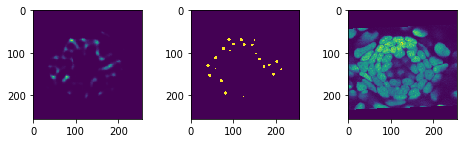

38788.76


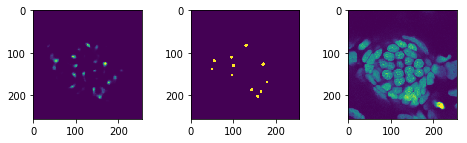

37461.492


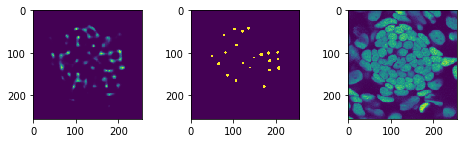

31662.592


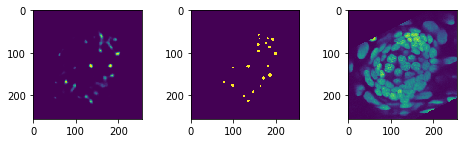

30611.27


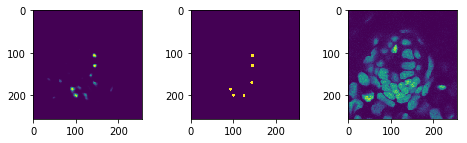

27280.71


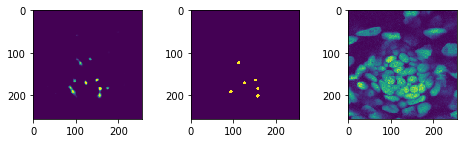

24804.895


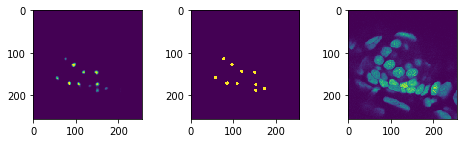

21023.477


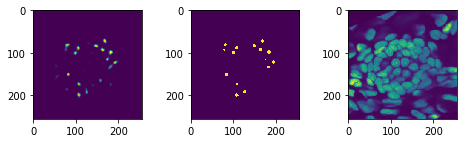

15996.736


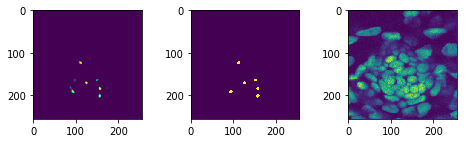

14727.194


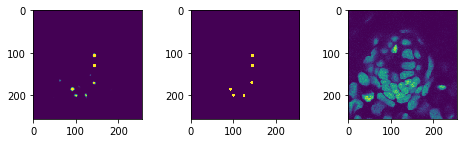

15408.016


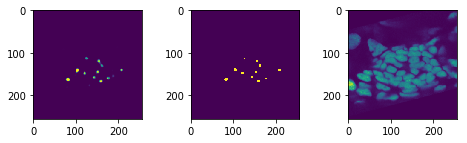

12810.15


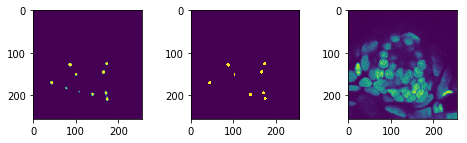

13083.658


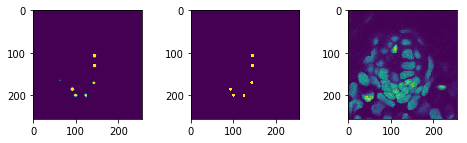

12810.992


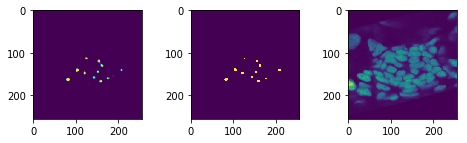

9816.584


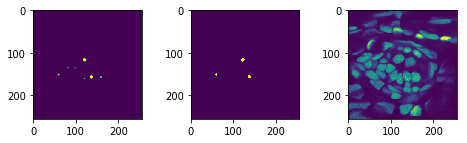

10712.438


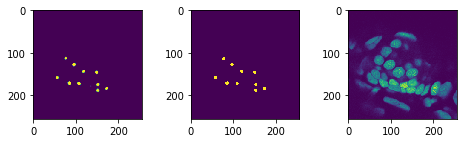

9403.449


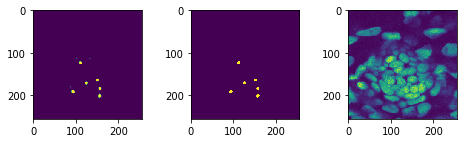

10049.948


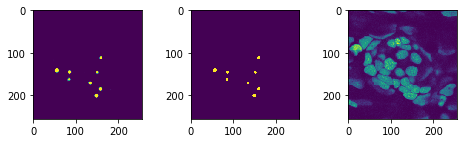

In [21]:
for i in range(1000):
    nr = np.random.randint(0,36, 8)
    bx = np.expand_dims(u.x[nr,:,:,:,0], -1)
    bm = np.expand_dims(u.x[nr,:,:,:,1], -1)
    _, res, err = sess.run([u.opt, u.decoder_sigmoid, u.loss], feed_dict={images:bx, masks:bm})
    if i % 20 == 0:
        print(err)
        plt.figure(figsize=(8,2))
        plt.subplot(1,3,1)
        plt.imshow(res[0,:,:,32,0])
        plt.subplot(1,3,2)
        plt.imshow(u.x[nr[0],:,:,32,1])
        plt.subplot(1,3,3)
        plt.imshow(u.x[nr[0],:,:,32,0])
        plt.show()

In [18]:
res.shape, u.x[nr,:,:,32,1].shape

((1, 256, 256, 64, 1), (1, 256, 256))

In [206]:
u.create_loss(masks)
ss = sess.run(u.loss, feed_dict={images:yy, masks:bb})

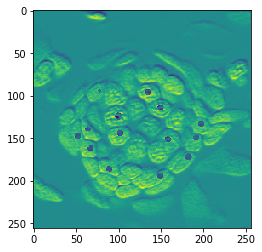

In [208]:
ss.shape
plt.imshow(ss[0,:,:,44,0])

In [219]:
rt = y[0,:,:,:,:]
from scipy.ndimage import rotate

res = rotate(rt, 45, (0, 1), order=2)

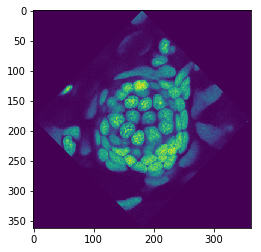

In [220]:
plt.imshow(res[:,:,44,0])